In [0]:
from fastai import *
from fastai.vision import *

In [2]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/labels')]

In [0]:
path_img = path/'images'
path_lbl = path/'labels'

In [4]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f00150.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_006990.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f01290.png')]

In [5]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0016E5_01410_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f03390_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_08083_P.png')]

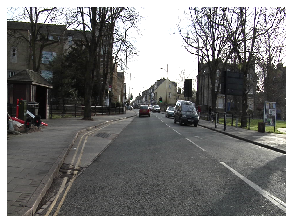

In [6]:
#image

img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
#function to map images and labels
get_y_fname = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

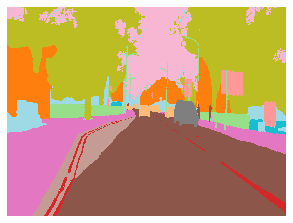

In [8]:
#mask

mask = open_mask(get_y_fname(img_f))
mask.show(figsize=(5,5), alpha=1)

In [18]:
#small batch size because we've to classify each pixel in the image

bs = 4
src_size = np.array(mask.shape[1:])
size = src_size//2
src_size

array([720, 960])

In [14]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fname, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True) #tfm_y=True means perform same transformation to segmented as to the original
        .databunch(bs=bs)
        .normalize(imagenet_stats))

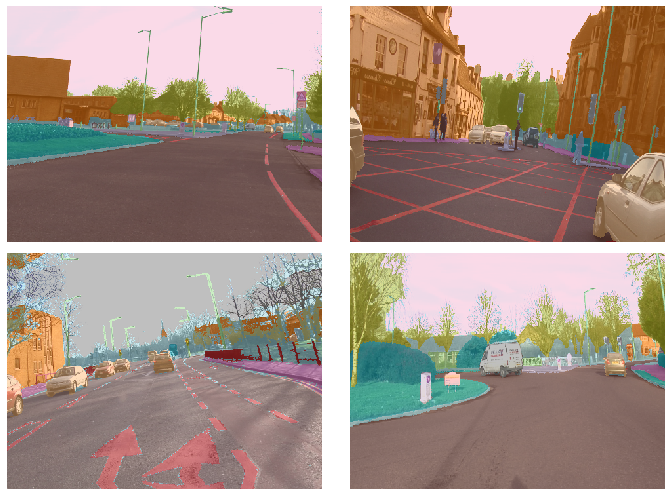

In [20]:
data.show_batch(2, figsize=(10,7))


In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

metrics=acc_camvid

In [22]:
learn = unet_learner(data, models.resnet34, metrics=metrics)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 168MB/s] 


epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


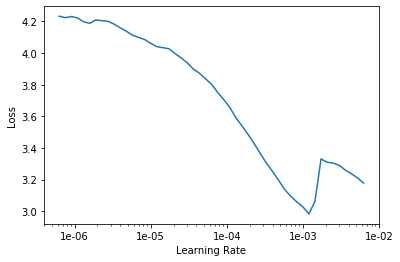

In [23]:
lr_find(learn)
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(10, slice(1e-04/4))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.392359,0.346278,0.900740,00:53
1,0.389308,0.344070,0.901704,00:53
2,0.395770,0.335046,0.905777,00:53
3,0.381814,0.328442,0.905814,00:53
4,0.376851,0.325489,0.909483,00:52
5,0.367210,0.325068,0.906874,00:52
6,0.352609,0.318814,0.907966,00:53
7,0.346019,0.318914,0.907166,00:53
8,0.340229,0.313651,0.909287,00:53
9,0.333132,0.313679,0.909499,00:52


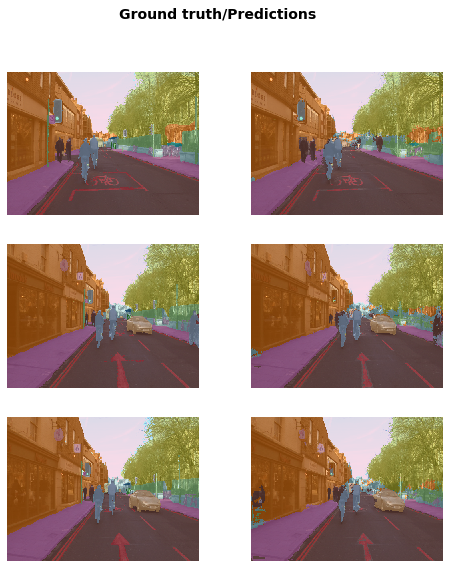

In [28]:
learn.save('stage-1')
learn.load('stage-1');
learn.show_results(rows=3, figsize=(8,9))

In [0]:
learn.unfreeze()
lr=3e-3
lrs = slice(lr/400,lr/4)

In [30]:
learn.fit_one_cycle(12, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.438103,0.404728,0.885922,00:55
1,0.529597,0.505319,0.862507,00:55
2,0.575842,0.418705,0.884677,00:55
3,0.493215,0.398244,0.889163,00:55
4,0.467042,0.360471,0.897672,00:55
5,0.411353,0.346282,0.904722,00:55
6,0.369186,0.358357,0.899058,00:55
7,0.334633,0.330115,0.911917,00:55
8,0.305861,0.278711,0.922969,00:55
9,0.271186,0.262889,0.926980,00:55


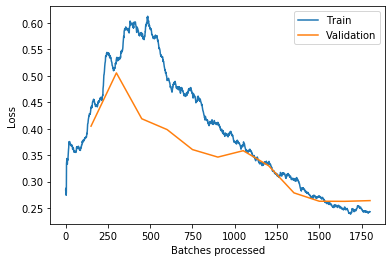

In [33]:
learn.recorder.plot_losses()

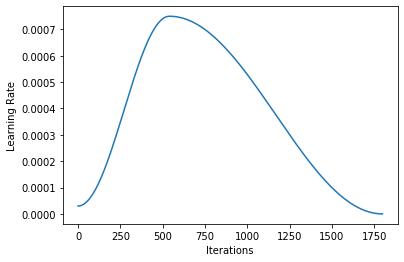

In [34]:
learn.recorder.plot_lr() #OneCycle